<a href="https://colab.research.google.com/github/ropholuo/ESE546-Intro-to-Deep-learning/blob/main/jinhuil_hw3_problem4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn

import numpy as np

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving book-war-and-peace.txt to book-war-and-peace.txt
User uploaded file "book-war-and-peace.txt" with length 3266164 bytes


Read file. Decode it from bytes to string. Remove \n

In [ ]:
file = uploaded['book-war-and-peace.txt'].decode('utf-8').replace('\n','')

Find the number of identical characters

In [ ]:
def lenOneHot(file, seqnum, seqlen):
  part = ""
  for i in range(1,seqnum):
    seq = file[(i-1)*seqlen:i*seqlen]
    part += seq
  data = set(part)
  m = len(data)
  return m, data

In [ ]:
m, data = lenOneHot(file, len(file), 25)
print(m)
print(data)

82
{'W', 'F', '-', 'q', 'é', 'h', 'G', 'V', 'Y', 'U', '!', '(', "'", 'K', ' ', '9', 'X', 'u', 'o', 'z', 'A', 'w', 'r', 'T', 'O', ':', '8', 'l', 'H', 'Z', 'Q', '5', 'f', 'i', 'E', 'x', 'j', 'L', 'ä', 'k', '*', '\r', 'd', 't', 'à', 'R', '1', 'm', 'a', 'N', 'M', '=', 'v', 's', 'b', 'n', ';', 'C', '/', 'J', 'I', '4', '6', 'c', 'B', 'p', '2', 'S', 'ê', '0', 'y', 'D', '3', '.', 'P', ',', '?', ')', '7', 'g', 'e', '"'}


In [ ]:
file[:100]

'CHAPTER I\r\r"Well, Prince, so Genoa and Lucca are now just family estates of the\rBuonapartes. But I w'

Dict for converting characters and integers

In [ ]:
int2char = dict(enumerate(data))
char2int = {char: ind for ind, char in int2char.items()}

In [ ]:
len(char2int)

82

Generate sequences of input and targets

In [ ]:
input = []
target = []
test, test_target = [], []
for i in range(10000):
  input.append(file[i:i+25])
  target.append(file[i+1:i+26])

for i in range(20000, 30000):
  test.append(file[i:i+25])
  test_target.append(file[i+1:i+26])

Convert input and target from characters to integers. Use half of the book.

In [ ]:
input_seq = []
target_seq = []
test_seq, test_target_seq = [], []
for i in range(10000):
  input_seq.append([char2int[char] for char in input[i]])
  target_seq.append([char2int[char] for char in target[i]])
  test_seq.append([char2int[char] for char in test[i]])
  test_target_seq.append([char2int[char] for char in test_target[i]])

In [ ]:
np.shape(input_seq)

(10000, 25, 82)

Encode input training data into one-hot

In [ ]:
dict_size = len(char2int)
seq_len = 25
batch_size = len(input_seq)

def oneHotEncoder(dict_size, seq_size, sequence, batch_size):
  features = np.zeros((batch_size, seq_size, dict_size), dtype=np.float32)

  for i in range(batch_size):
    for j in range(seq_size):
      features[i, j, sequence[i][j]] = 1

  return features

In [ ]:
input_seq = oneHotEncoder(dict_size, seq_len, input_seq, batch_size)
test_seq = oneHotEncoder(dict_size, seq_len, test_seq, batch_size)

**(b)**

In [ ]:
input_seq = torch.from_numpy(input_seq)
target_seq = torch.Tensor(target_seq)
test_seq = torch.from_numpy(test_seq)
test_target_seq = torch.Tensor(test_target_seq)

In [ ]:
trainset = torch.utils.data.TensorDataset(input_seq, target_seq)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True)
testset = torch.utils.data.TensorDataset(test_seq, test_target_seq)
test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("GPU is available")
else:
  device = torch.device("cpu")
  print("GPU not available")

GPU is available


In [ ]:
class myrnn(nn.Module):
  def __init__(self, input_size, output_size, hidden_dim, n_layers):
    super(myrnn, self).__init__()

    self.hidden_dim = hidden_dim
    self.n_layers = n_layers

    self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_size)
    self.batchnorm = nn.BatchNorm1d(hidden_dim)

  def forward(self, x):
    batch_size = x.size(0)

    hidden = self.init_hidden(batch_size)
    hidden = hidden.to(device)

    out, hidden = self.rnn(x, hidden)
    # out = out.permute(0, 2, 1)
    # out = self.batchnorm(out)
    out = out.contiguous().view(-1, self.hidden_dim)
    out = self.fc(out)

    return out, hidden

  def init_hidden(self, batch_size):
    hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)

    return hidden

In [ ]:
x, y = next(iter(train_loader))

In [ ]:
x.shape

torch.Size([1, 25, 82])

In [ ]:
def train(model, optimizer, criterion, train_loader, epochs):
  model = model.to(device)
  total_step = len(train_loader)
  overall_step = 0
  train_loss, test_loss = [], []

  for epoch in range(epochs):
    model.train()
    for i, (input, target) in enumerate(train_loader):
      input = input.to(device)
      target = target.to(device)
      
      optimizer.zero_grad()
      output, hidden = model(input)
      loss = criterion(output, target.view(-1).long())
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
      optimizer.step()

      if (i+1) % 1000 == 0:
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
        train_loss.append(loss.item())


    print('-'*50)



    model.eval()
    with torch.no_grad():
      correct, total = 0, 0
      for i, (input, target) in enumerate(test_loader):
        input = input.to(device)
        target = target.to(device)
        output, _ = model(input)
        loss = criterion(output, target.view(-1).long())

    print('Loss of the network on the testset: {}'.format(loss.item()))
    test_loss.append(loss.item())

  return train_loss, test_loss

In [ ]:
model = myrnn(input_size=dict_size, output_size=dict_size, hidden_dim=256, n_layers=1)
model.to(device)

lr = 10**(-3)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
train_loss, test_loss = train(model, optimizer, criterion, train_loader, 20)

Epoch [1/20], Step [1000/10000], Loss: 2.8683
Epoch [1/20], Step [2000/10000], Loss: 1.7181
Epoch [1/20], Step [3000/10000], Loss: 3.1826
Epoch [1/20], Step [4000/10000], Loss: 2.5238
Epoch [1/20], Step [5000/10000], Loss: 2.3488
Epoch [1/20], Step [6000/10000], Loss: 2.0881
Epoch [1/20], Step [7000/10000], Loss: 2.6112
Epoch [1/20], Step [8000/10000], Loss: 1.7514
Epoch [1/20], Step [9000/10000], Loss: 1.7025
Epoch [1/20], Step [10000/10000], Loss: 1.3227
--------------------------------------------------
Loss of the network on the testset: 2.5982089042663574
Epoch [2/20], Step [1000/10000], Loss: 1.0370
Epoch [2/20], Step [2000/10000], Loss: 1.6448
Epoch [2/20], Step [3000/10000], Loss: 1.7867
Epoch [2/20], Step [4000/10000], Loss: 1.4622
Epoch [2/20], Step [5000/10000], Loss: 1.3078
Epoch [2/20], Step [6000/10000], Loss: 1.1150
Epoch [2/20], Step [7000/10000], Loss: 0.7827
Epoch [2/20], Step [8000/10000], Loss: 1.0024
Epoch [2/20], Step [9000/10000], Loss: 1.3866
Epoch [2/20], Step 

In [ ]:
np.shape(train_loss)

(200,)

Gonna take too long to run so only go through the testset once every epoch instead of per 1k updates

Text(0.5, 0, 'epochs')

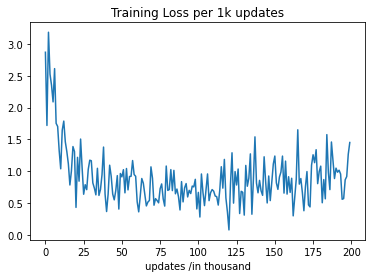

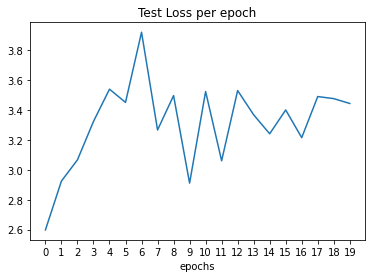

In [ ]:
import matplotlib.pyplot as plt

plt.figure(); plt.plot(range(200), train_loss); plt.title('Training Loss per 1k updates');plt.xlabel('updates /in thousand')
plt.figure(); plt.plot(range(20), test_loss); plt.title('Test Loss per epoch'); plt.xticks(range(20)); plt.xlabel('epochs')

Input characters into model and transfer output from int to chars

In [ ]:
def predict(model, char):
  char = np.array([[char2int[c] for c in char]])
  char = oneHotEncoder(dict_size, char.shape[1], char, 1)
  char = torch.from_numpy(char)
  char = char.to(device)

  out, hidden = model(char)

  prob = nn.functional.softmax(out[-1], dim=0).data
  char_ind = torch.max(prob, dim=0)[1].item()

  return int2char[char_ind], hidden

In [ ]:
def sample(model, out_len, start):
  model.eval()
  chars = [c for c in start]
  size = out_len - len(chars)
  
  for i in range(200):
    char, h = predict(model, chars)
    chars.append(char)

  return ''.join(chars)

In [ ]:
sample(model, 25, 'this')

'this ingiter? Betmaply ended court. He cres all Englishe said at last. "You know that has been decirid he in Furke to had been\rpus it?" said the prince bowed with ant or\rhis all yourseve that morench rald'